<a href="https://colab.research.google.com/github/Jmmostafa/QuantRisk/blob/main/QR004_OptionsVolatilityModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Volatility Surface**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | June 7, 2025  |
|**Covered** | Options Volatlity, Application |
|**Sequence** | QR004 |


---

# Introduction


### **Options Basics**
- Contracts giving the right (not obligation) to buy/sell assets at set prices.
- Key pricing factors:
  - Underlying price
  - Strike price
  - Time to expiry
  - Interest rates
  - **Volatility** (most critical input)



# Option Pricing Model (BS Model)
There are several options pricing models. Here I start with one of the fundamental models called **Black-Scholes Model**. Later, I will add the complexity to fine tune the model estimations and appropriateness as we move forward.

BS model computes the prices of the options as

### Call Option Price:
$$
C(S_t, K, T, r, \sigma) = S_tN(d_1) - Ke^{-rT}N(d_2)
$$

### Put Option Price:
$$
P(S_t, K, T, r, \sigma) = Ke^{-rT}N(-d_2) - S_tN(-d_1)
$$

- Where:
$$
d_1 = \frac{\ln(S_t/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}} \\
d_2 = d_1 - \sigma\sqrt{T}
$$

- $S_t$ = Current stock price
- $K$ = Strike price
- $T$ = Time to expiration (years)
- $r$ = Risk-free rate
- $\sigma$ = Volatility
- $N$ = Standard normal CDF



## Implied Volatility (IV)

- **The market's forecast** of how much a stock/asset might move
- **Embedded in option prices** - higher IV = more expensive options
- **Not actual volatility** (it's what traders *expect* will happen)

### **Dynamics**  
   - Changes constantly based on:
     - Market fear/greed
     - Upcoming events (earnings, Fed decisions)
     - Supply/demand for options

- **Options pricing**: Higher IV → more expensive options  
- **Trading signals**:  
  - High IV = potential overpriced options (sell opportunities)  
  - Low IV = potential underpriced options (buy opportunities)

# Options Data

In [108]:
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [109]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import scienceplots


# Helper function to get next Friday's date
def next_friday():
    today = datetime.today()
    days_to_friday = (4 - today.weekday()) % 7
    return today + timedelta(days=days_to_friday)

# Get live data
aapl = yf.Ticker("AAPL")
expiry_date = next_friday().strftime('%Y-%m-%d')
opt = aapl.option_chain(expiry_date)
calls = opt.calls.dropna(subset=['lastPrice'])  # Remove options with no price

# Market parameters
S = aapl.history(period="1d")["Close"].iloc[-1]
r = 0.0415  # Current risk-free rate (approximate)
expiry_datetime = pd.to_datetime(expiry_date)
T = (expiry_datetime - pd.Timestamp.today()).days / 365

# Options Volatility
## Key Functions

In [110]:
# Black-Scholes calculation
def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Implied volatility calculation
def implied_vol(S, K, T, r, market_price, option_type):
    def objective(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return brentq(objective, 0.01, 5.0)
    except ValueError:
        return np.nan

## Calculating IV

In [111]:
# Calculate IV for top 100 strikes
iv_results = []
valid_strikes = calls.strike.unique()[:100]

for K in valid_strikes:
    strike_data = calls[calls.strike == K]
    market_price = strike_data['lastPrice'].mean()

    if market_price > 0 and not np.isnan(market_price):
        iv = implied_vol(S, K, T, r, market_price, 'call')
        iv_results.append({
            'Strike': K,
            'Price': market_price,
            'IV': iv if not np.isnan(iv) else None,
            'Moneyness': 'ITM' if K < S else ('OTM' if K > S else 'ATM')
        })

# Create and display results
iv_df = pd.DataFrame(iv_results).dropna()
iv_df.head()

,Strike,Price,IV,Moneyness
5,140.0,64.75,1.929435,ITM
9,160.0,45.00,1.431916,ITM
10,165.0,39.55,1.121782,ITM
11,170.0,34.95,1.127423,ITM
12,175.0,30.40,1.099276,ITM


## Volatility Smile

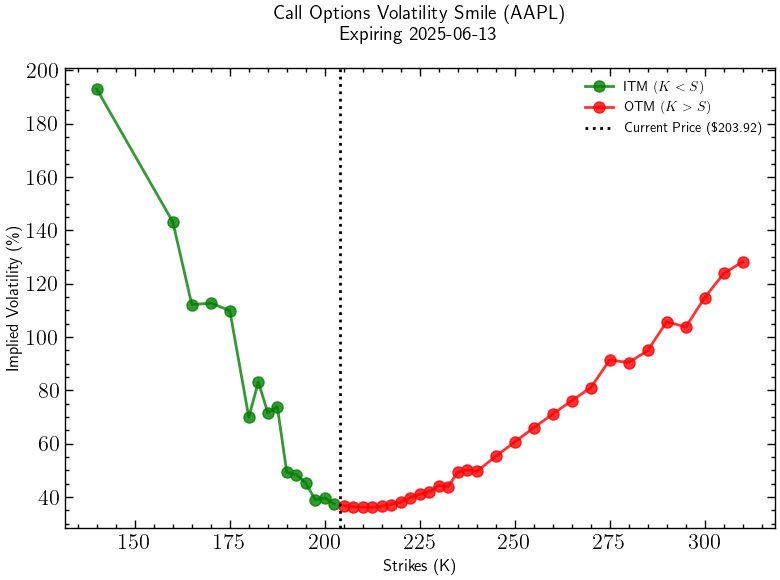

In [112]:
# Visualization with ITM/OTM color coding
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(8, 6))
plt.rcParams['text.usetex'] = True

# Separate ITM and OTM options
itm = iv_df[iv_df['Strike'] < S]
otm = iv_df[iv_df['Strike'] > S]
atm = iv_df[iv_df['Strike'] == S]

# Plot ITM options (green)
plt.plot(itm['Strike'], itm['IV']*100, 'go-', markersize=8, label='ITM $(K < S)$', alpha=0.8)

# Plot OTM options (red)
plt.plot(otm['Strike'], otm['IV']*100, 'ro-', markersize=8, label='OTM $(K > S)$', alpha=0.8)

# Plot ATM point if exists (blue)
if not atm.empty:
    plt.plot(atm['Strike'], atm['IV']*100, 'bo', markersize=10, label='ATM $(K = S)$')

# Add current price line
plt.axvline(x=S, color='k', linestyle=':', linewidth=2, label=f'Current Price (\${S:.2f})')

# Style the plot
plt.xlabel('Strikes (K)', fontsize=12)
plt.ylabel('Implied Volatility (\%)', fontsize=12)
plt.title(f'Call Options Volatility Smile (AAPL) \nExpiring {expiry_date}', fontsize=14, pad=20)
plt.legend(frameon=False, shadow=False, fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

## Volatility Surface

In [113]:
# Combining previous parts together
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


def implied_vol(S, K, T, r, market_price, option_type='call'):
    def objective(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return brentq(objective, 0.01, 5.0)
    except ValueError:
        return np.nan


def get_expiry_dates(ticker):
    return yf.Ticker(ticker).options


def calculate_volatility_surface(ticker='AAPL', risk_free_rate=0.0415):
    stock = yf.Ticker(ticker)
    S = stock.history(period='1d')['Close'].iloc[-1]
    expiry_dates = get_expiry_dates(ticker)[:100]

    surface_data = []

    for expiry in expiry_dates:
        opt = stock.option_chain(expiry)
        calls = opt.calls.dropna(subset=['lastPrice'])
        puts = opt.puts.dropna(subset=['lastPrice'])

        expiry_date = pd.to_datetime(expiry)
        T = (expiry_date - pd.Timestamp.today()).days / 365

        # Process calls
        for _, row in calls.iterrows():
            iv = implied_vol(S, row['strike'], T, risk_free_rate, row['lastPrice'], 'call')
            if not np.isnan(iv):
                surface_data.append([row['strike'], T, iv, 'call'])

        # Process puts
        for _, row in puts.iterrows():
            iv = implied_vol(S, row['strike'], T, risk_free_rate, row['lastPrice'], 'put')
            if not np.isnan(iv):
                surface_data.append([row['strike'], T, iv, 'put'])

    return pd.DataFrame(surface_data, columns=['Strike', 'TTM', 'IV', 'Type'])


# Calculate volatility surface
vol_surface = calculate_volatility_surface()


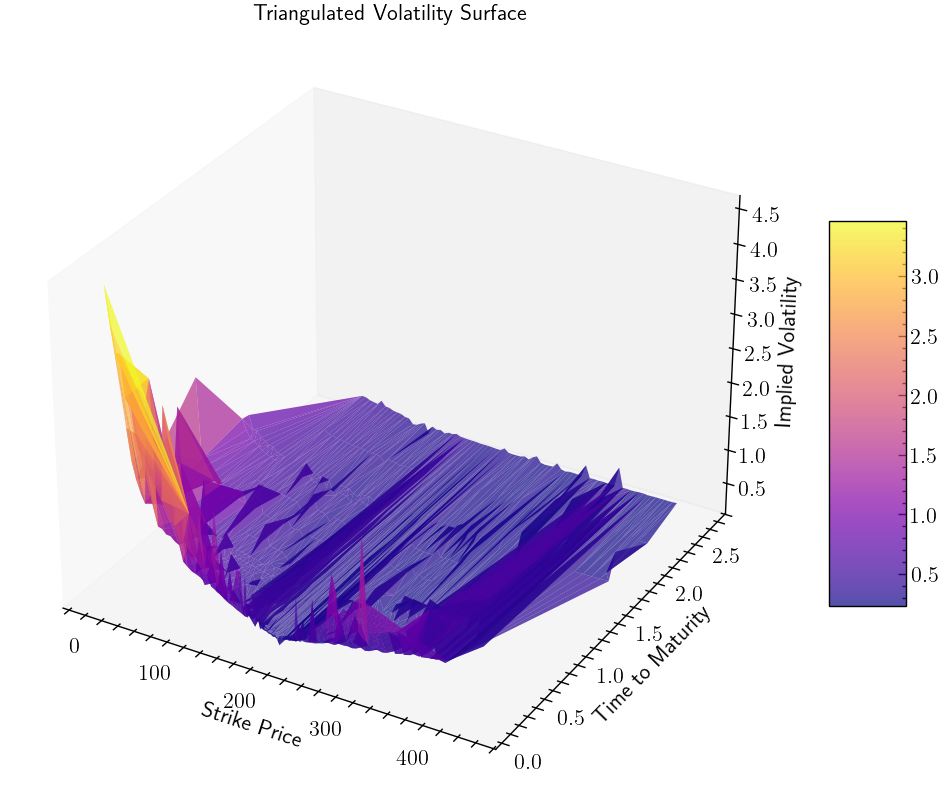

In [114]:
# Plotting the volatility surface using 3D graph
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# No interpolation needed
trisurf = ax.plot_trisurf(vol_surface.Strike, vol_surface.TTM, vol_surface.IV,
                        cmap='plasma',
                        edgecolor='none',
                        alpha=0.7)

ax.grid(False)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Triangulated Volatility Surface')
fig.colorbar(trisurf, shrink=0.5, aspect=5)
plt.show()

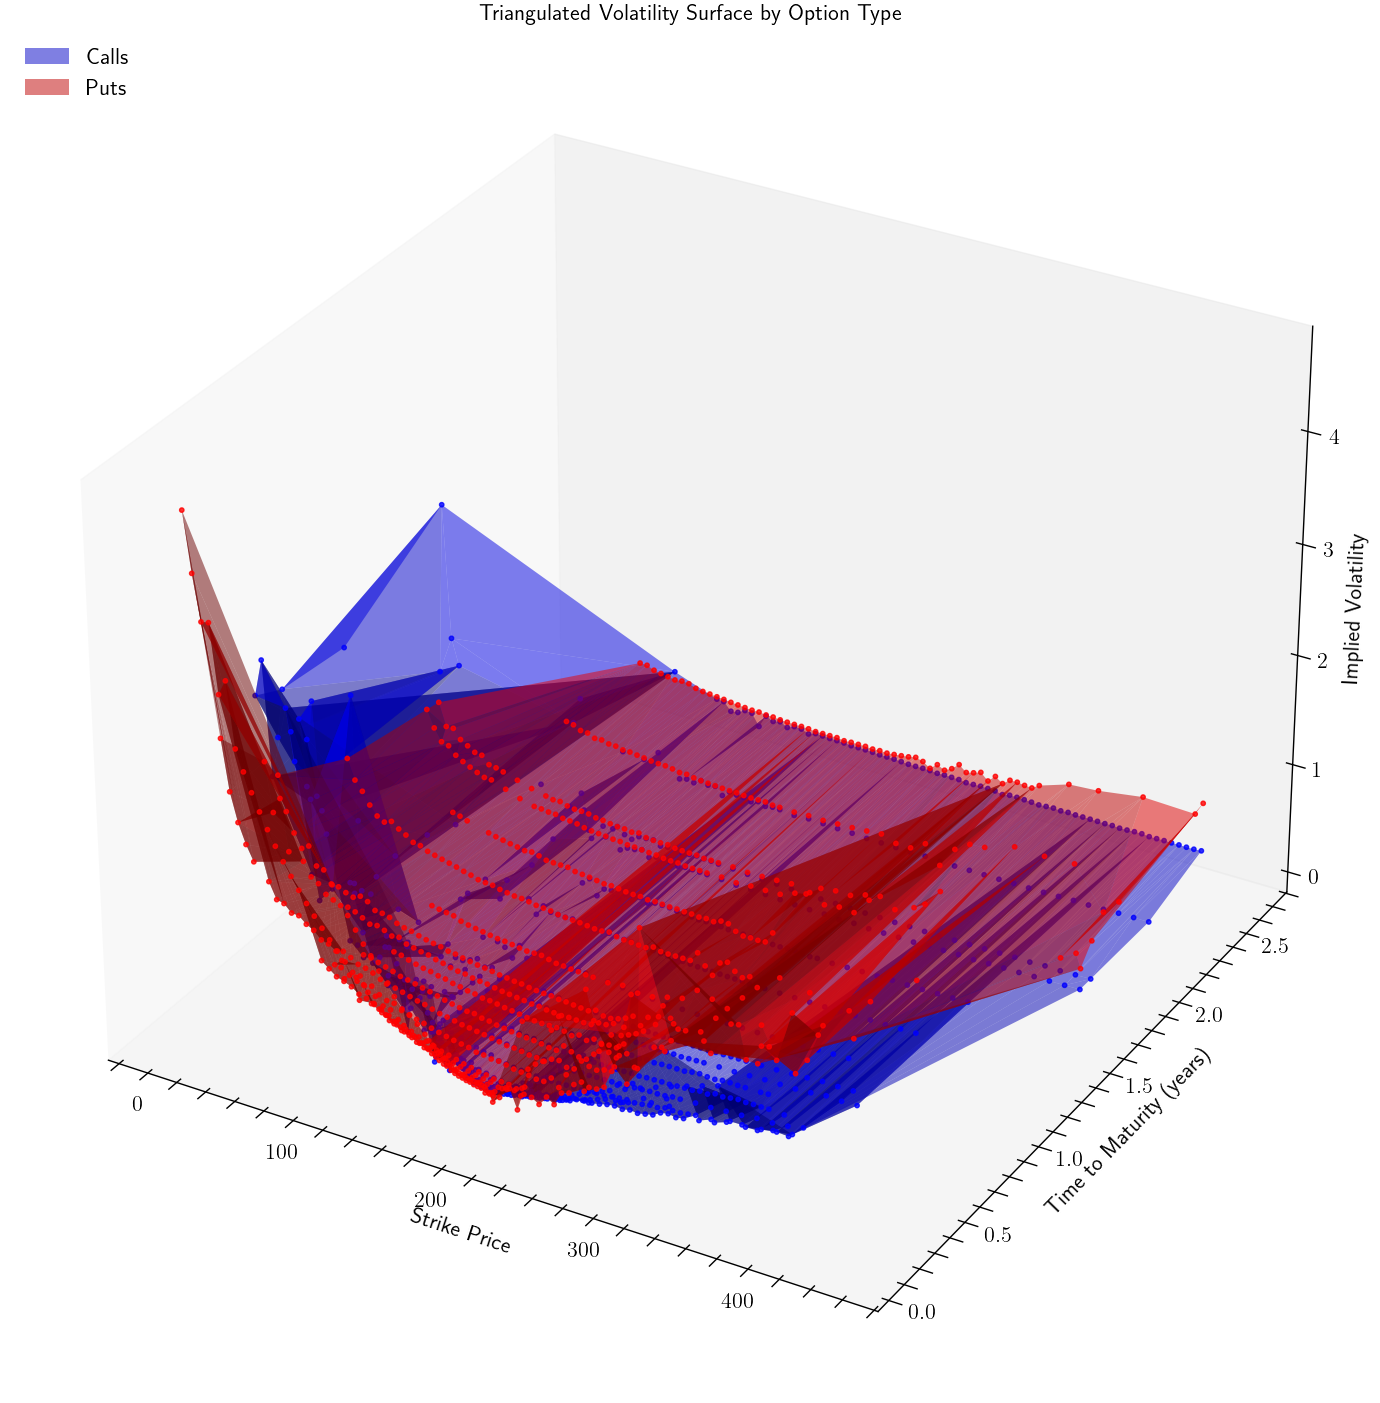

In [115]:
# Again, let's plot for identifying the call and puts
fig = plt.figure(figsize=(14, 16))
ax = fig.add_subplot(111, projection='3d')

# Create separate datasets for calls and puts
calls = vol_surface[vol_surface['Type'] == 'call']
puts = vol_surface[vol_surface['Type'] == 'put']

# Triangulated surface for calls (blue)
trisurf_call = ax.plot_trisurf(calls['Strike'], calls['TTM'], calls['IV'],
                             color='blue',
                             edgecolor='none',
                             alpha=0.5,
                             label='Calls')

# Triangulated surface for puts (red)
trisurf_put = ax.plot_trisurf(puts['Strike'], puts['TTM'], puts['IV'],
                            color='red',
                            edgecolor='none',
                            alpha=0.5,
                            label='Puts')

# Add scatter points to highlight individual options
ax.scatter(calls['Strike'], calls['TTM'], calls['IV'],
          color='blue', s=10, alpha=0.8)
ax.scatter(puts['Strike'], puts['TTM'], puts['IV'],
          color='red', s=10, alpha=0.8)

ax.grid(False)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Triangulated Volatility Surface by Option Type')

# Create proxy artists for legend
# from matplotlib.patches import Patch
# legend_elements = [
#     Patch(facecolor='blue', alpha=0.5, label='Call Options'),
#     Patch(facecolor='red', alpha=0.5, label='Put Options')
# ]
ax.legend(loc='upper left', frameon = False)

plt.tight_layout()
plt.show()

# **References**

- Gatheral, J. (2006). *The volatility surface: a practitioner's guide (Vol. 357)*. John Wiley & Sons.

- Black, Fischer; Scholes, Myron (1973). *The Pricing of Options and Corporate Liabilities*. Journal of Political Economy. 81 (3): 637–654. doi:10.1086/260062

- Hull, John C. (2008). *Options, Futures and Other Derivatives (7th ed.)*. Prentice Hall. ISBN 978-0-13-505283-9.